本笔记中的代码来自 [Recurrent Neural Networks in Tensorflow I](https://r2rt.com/recurrent-neural-networks-in-tensorflow-i.html)。这是一篇介绍 RNN 实现的非常棒的文章，非常清晰易懂，强烈推荐。

## Imports, config variables, and data generators

In [1]:
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt

# Global config variables
num_steps = 5 # number of truncated backprop steps ('n' in the discussion above)
batch_size = 200
num_classes = 2
state_size = 4
learning_rate = 0.1

def gen_data(size=1000000):
    X = np.array(np.random.choice(2, size=(size,)))
    Y = []
    for i in range(size):
        threshold = 0.5
        if X[i-3] == 1:
            threshold += 0.5
        if X[i-8] == 1:
            threshold -= 0.25
        if np.random.rand() > threshold:
            Y.append(0)
        else:
            Y.append(1)
    return X, np.array(Y)

# adapted from https://github.com/tensorflow/tensorflow/blob/master/tensorflow/models/rnn/ptb/reader.py
def gen_batch(raw_data, batch_size, num_steps):
    raw_x, raw_y = raw_data
    data_length = len(raw_x)

    # partition raw data into batches and stack them vertically in a data matrix
    batch_partition_length = data_length // batch_size
    data_x = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    data_y = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    for i in range(batch_size):
        data_x[i] = raw_x[batch_partition_length * i:batch_partition_length * (i + 1)]
        data_y[i] = raw_y[batch_partition_length * i:batch_partition_length * (i + 1)]
    # further divide batch partitions into num_steps for truncated backprop
    epoch_size = batch_partition_length // num_steps

    for i in range(epoch_size):
        x = data_x[:, i * num_steps:(i + 1) * num_steps]
        y = data_y[:, i * num_steps:(i + 1) * num_steps]
        yield (x, y)

def gen_epochs(n, num_steps):
    for i in range(n):
        yield gen_batch(gen_data(), batch_size, num_steps)

## Model

In [2]:
"""
Placeholders
"""

x = tf.placeholder(tf.int32, [batch_size, num_steps], name='input_placeholder')
y = tf.placeholder(tf.int32, [batch_size, num_steps], name='labels_placeholder')
init_state = tf.zeros([batch_size, state_size])

"""
RNN Inputs
"""

# Turn our x placeholder into a list of one-hot tensors:
# rnn_inputs is a list of num_steps tensors with shape [batch_size, num_classes]
x_one_hot = tf.one_hot(x, num_classes)
rnn_inputs = tf.unstack(x_one_hot, axis=1)

"""
Definition of rnn_cell

This is very similar to the __call__ method on Tensorflow's BasicRNNCell. See:
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/rnn/python/ops/core_rnn_cell_impl.py#L95
"""
with tf.variable_scope('rnn_cell'):
    W = tf.get_variable('W', [num_classes + state_size, state_size])
    b = tf.get_variable('b', [state_size], initializer=tf.constant_initializer(0.0))

def rnn_cell(rnn_input, state):
    with tf.variable_scope('rnn_cell', reuse=True):
        W = tf.get_variable('W', [num_classes + state_size, state_size])
        b = tf.get_variable('b', [state_size], initializer=tf.constant_initializer(0.0))
    return tf.tanh(tf.matmul(tf.concat([rnn_input, state], 1), W) + b)

"""
Adding rnn_cells to graph

This is a simplified version of the "static_rnn" function from Tensorflow's api. See:
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/rnn/python/ops/core_rnn.py#L41
Note: In practice, using "dynamic_rnn" is a better choice that the "static_rnn":
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/ops/rnn.py#L390
"""
state = init_state
rnn_outputs = []
for rnn_input in rnn_inputs:
    state = rnn_cell(rnn_input, state)
    rnn_outputs.append(state)
final_state = rnn_outputs[-1]

"""
Predictions, loss, training step

Losses is similar to the "sequence_loss"
function from Tensorflow's API, except that here we are using a list of 2D tensors, instead of a 3D tensor. See:
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/seq2seq/python/ops/loss.py#L30
"""

#logits and predictions
with tf.variable_scope('softmax'):
    W = tf.get_variable('W', [state_size, num_classes])
    b = tf.get_variable('b', [num_classes], initializer=tf.constant_initializer(0.0))
logits = [tf.matmul(rnn_output, W) + b for rnn_output in rnn_outputs]
predictions = [tf.nn.softmax(logit) for logit in logits]

# Turn our y placeholder into a list of labels
y_as_list = tf.unstack(y, num=num_steps, axis=1)

#losses and train_step
losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(labels=label, logits=logit) for logit, label in zip(logits, y_as_list)]
total_loss = tf.reduce_mean(losses)
train_step = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)

## Train the Network

In [3]:
"""
Train the network
"""

def train_network(num_epochs, num_steps, state_size=4, verbose=True):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        training_losses = []
        for idx, epoch in enumerate(gen_epochs(num_epochs, num_steps)):
            training_loss = 0
            training_state = np.zeros((batch_size, state_size))
            if verbose:
                print("\nEPOCH", idx)
            for step, (X, Y) in enumerate(epoch):
                tr_losses, training_loss_, training_state, _ = \
                    sess.run([losses,
                              total_loss,
                              final_state,
                              train_step],
                                  feed_dict={x:X, y:Y, init_state:training_state})
                training_loss += training_loss_
                if step % 100 == 0 and step > 0:
                    if verbose:
                        print("Average loss at step", step,
                              "for last 250 steps:", training_loss/100)
                    training_losses.append(training_loss/100)
                    training_loss = 0

    return training_losses

('\nEPOCH', 0)
('Average loss at step', 100, 'for last 250 steps:', 0.60223139226436617)
('Average loss at step', 200, 'for last 250 steps:', 0.55299137711524959)
('Average loss at step', 300, 'for last 250 steps:', 0.5230247250199318)
('Average loss at step', 400, 'for last 250 steps:', 0.52261269330978388)
('Average loss at step', 500, 'for last 250 steps:', 0.52028543651103976)
('Average loss at step', 600, 'for last 250 steps:', 0.52070176601409912)
('Average loss at step', 700, 'for last 250 steps:', 0.5204971581697464)
('Average loss at step', 800, 'for last 250 steps:', 0.51935682028532026)
('Average loss at step', 900, 'for last 250 steps:', 0.51897449523210526)


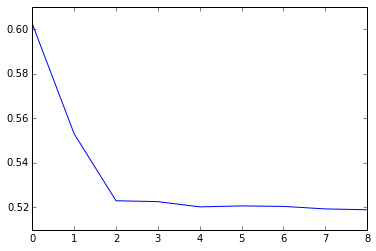

In [4]:
training_losses = train_network(1,num_steps)
plt.plot(training_losses)

## Inspect

参数

In [20]:
from __future__ import print_function
print("num_steps = %d, batch_size = %d, num_classes = %d, state_size = %d, learning_rate = %.4f" % 
      (num_steps, batch_size, num_classes, state_size, learning_rate))

num_steps = 5, batch_size = 200, num_classes = 2, state_size = 4, learning_rate = 0.1000


In [22]:
num_epochs = 1
for idx, epoch in enumerate(gen_epochs(num_epochs, num_steps)):
    if idx > 0:
        continue
    for step, (X, Y) in enumerate(epoch):
        if step > 0:
            continue
        print("shape of X: ", X.shape)
        print("shape of Y: ", Y.shape)

shape of X:  (200, 5)
shape of Y:  (200, 5)


数据的划分

In [33]:
data_size = 1000000
batch_partition_length = data_size // batch_size # = 1000000 // 200 = 5000
epoch_size = batch_partition_length // num_steps # = 5000 // 5 = 1000
data_x = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
data_x.shape, data_x[:, 1 * num_steps: 2 * num_steps].shape

((200, 5000), (200, 5))

>个人理解， 一个 batch 中元素的个数是1000个，因为模型的宽度是5， 所以分成了200行5列。在代码中，epoch_size 实际上是 num_of_batches， 也就是1000。这样命令容易引起误解。

In [40]:
x, y, init_state, x_one_hot, len(rnn_inputs), rnn_inputs[0]

(<tf.Tensor 'input_placeholder:0' shape=(200, 5) dtype=int32>,
 <tf.Tensor 'labels_placeholder:0' shape=(200, 5) dtype=int32>,
 <tf.Tensor 'zeros:0' shape=(200, 4) dtype=float32>,
 <tf.Tensor 'one_hot:0' shape=(200, 5, 2) dtype=float32>,
 5,
 <tf.Tensor 'unstack:0' shape=(200, 2) dtype=float32>)

以上的输出是对于一个 Graph 来说的。一个 Graph 包含step_size(5)个 Cell, 每个 Cell 的输入是 batch_size * num_classes ( 200 * 2)维度的输入。

In [49]:
with tf.variable_scope('rnn_cell', reuse=True):
        W = tf.get_variable('W', [num_classes + state_size, state_size])
        b = tf.get_variable('b', [state_size], initializer=tf.constant_initializer(0.0))
new_state = tf.tanh(tf.matmul(tf.concat([rnn_inputs[0], init_state], 1), W) + b)
tf.concat([rnn_inputs[0], state], 1), W, b, new_state

(<tf.Tensor 'concat_13:0' shape=(200, 6) dtype=float32>,
 <tf.Variable 'rnn_cell/W:0' shape=(6, 4) dtype=float32_ref>,
 <tf.Variable 'rnn_cell/b:0' shape=(4,) dtype=float32_ref>,
 <tf.Tensor 'Tanh_7:0' shape=(200, 4) dtype=float32>)

In [53]:
W2 = tf.get_variable('W2', [state_size, num_classes])
b2 = tf.get_variable('b2', [num_classes], initializer=tf.constant_initializer(0.0))
logits = [tf.matmul(rnn_output, W2) + b2 for rnn_output in rnn_outputs]
predictions = [tf.nn.softmax(logit) for logit in logits]

In [58]:
len(rnn_outputs), rnn_outputs[0], W2, b2, "logits:", len(logits), logits[0], "predictions:", len(predictions), predictions[0]

(5,
 <tf.Tensor 'Tanh:0' shape=(200, 4) dtype=float32>,
 <tf.Variable 'W2:0' shape=(4, 2) dtype=float32_ref>,
 <tf.Variable 'b2:0' shape=(2,) dtype=float32_ref>,
 'logits:',
 5,
 <tf.Tensor 'add_13:0' shape=(200, 2) dtype=float32>,
 'predictions:',
 5,
 <tf.Tensor 'Softmax_5:0' shape=(200, 2) dtype=float32>)

In [61]:
y_as_list[0]

<tf.Tensor 'unstack_1:0' shape=(200,) dtype=int32>

在 run 模型的时候，init_state被设置成了上一次运行结果的返回值。所以`init_state = tf.zeros([batch_size, state_size])`这一行是没有必要的。

In [67]:

sess2 = tf.Session()
tmp = tf.zeros([5])
print(sess2.run(tmp))
tmp = tf.constant([1., 2, 3.])
print(sess2.run(tmp))

[ 0.  0.  0.  0.  0.]
[ 1.  2.  3.]


Change to Tensorflow API
```
cell = tf.contrib.rnn.BasicRNNCell(state_size)
rnn_outputs, final_state = tf.contrib.rnn.static_rnn(cell, rnn_inputs, initial_state=init_state)
```

原文链接: [Recurrent Neural Networks in Tensorflow I](https://r2rt.com/recurrent-neural-networks-in-tensorflow-i.html)